Simple polynomial regression of Corona virus cases by state

Source data: US county covid records from NY times: https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv

I tried county data, but there's not sufficient datasets for this analysis. Statewide data shows some results.

As any statistician will caution me: the sampling of cases will skew the data. It's going to be a long time before truly random sampling is feasible.

This algo:

* read the data, group by state to get cases
* generate a time-series based on first detected case in a state
* map a polynomial (4th order) to the change in cases per day
* plot the estimated values vs current, projecting 10 days forward
* highlight a red/green where the rate of change of cases is decreasing 


# imports we use

In [1]:
import torch
import datetime

import matplotlib.pyplot as plt
import csv

### Process Data

data is an array of total accumulate number of cases since the first case
example: [ 1,1,1,3,4,5,5,6 ] shows one case detected $day_0$, then 2 more on $day_3$, another on $day_4$ and another on $day_5$ and one more on $day_7$

So if we have a list of x values and y values we can produce a polynomial best fit like this...

$$
    y_0 = f( x_0 ) \\
    y_1 = f( x_1 ) \\
    y_2 = f( x_2 ) \\
    y_3 = f( x_3 ) \\
    \vdots \\
    y_n = f( x_n ) \\    
$$

$$
\begin{equation*}\mathbf{}
\left[\begin{matrix}
\Sigma_{i=0}^{n} {x_i^8} & \Sigma_{i=0}^{n} {x_i^7} & \Sigma_{i=0}^{n} {x_i^6} & \Sigma_{i=0}^{n} {x_i^5} & \Sigma_{i=0}^{n} {x_i^4} \\ 
\Sigma_{i=0}^{n} {x_i^7} & \Sigma_{i=0}^{n} {x_i^6} & \Sigma_{i=0}^{n} {x_i^5} & \Sigma_{i=0}^{n} {x_i^4} & \Sigma_{i=0}^{n} {x_i^3} \\ 
\Sigma_{i=0}^{n} {x_i^6} & \Sigma_{i=0}^{n} {x_i^5} & \Sigma_{i=0}^{n} {x_i^4} & \Sigma_{i=0}^{n} {x_i^3} & \Sigma_{i=0}^{n} {x_i^2} \\ 
\Sigma_{i=0}^{n} {x_i^5} & \Sigma_{i=0}^{n} {x_i^4} & \Sigma_{i=0}^{n} {x_i^3} & \Sigma_{i=0}^{n} {x_i^2} & \Sigma_{i=0}^{n} {x_i} \\ 
\Sigma_{i=0}^{n} {x_i^4} & \Sigma_{i=0}^{n} {x_i^3} & \Sigma_{i=0}^{n} {x_i^2} & \Sigma_{i=0}^{n} {x_i} & n
\end{matrix}\right] 
\mathbf{}
\left[\begin{matrix}
a \\ b \\ c \\ d \\ e
\end{matrix}\right] 
=
\mathbf{}
\left[\begin{matrix}
\Sigma_{i=0}^{n} {x^4 y_i} \\ \Sigma_{i=0}^{n} {x_i^3 y_i} \\ \Sigma_{i=0}^{n} {x_i^2 y_i} \\ \Sigma_{i=0}^{n} {x_i y_i} \\ \Sigma_{i=0}^{n} {y_i}
\end{matrix}\right] 
\end{equation*}
$$

Equation of this form ...

$$
    A x = b
$$

So using crappy linear algebra (we all know inverting a matrix is bad right? Especially one with a condition number like this)
$$
    A^{-1} A x = A^{-1} b \\
    I x = A^{-1} b \\
    x = A^{-1} b
$$

Ideally I'll add a QR solution...to get this

$$
\hat y = a x^4 + b x^3 + c x^2 + d x + e 
$$



In [2]:
def processData(state, data):
    delta = []
    gamma = []

    for i in range(1, len(data)):
        delta.append(data[i] - data[i - 1])

    deltaMid = []
    for i in range(1, len(delta)):
        gamma.append(delta[i] - delta[i - 1])
        deltaMid.append((delta[i] - delta[i - 1]) / 2.0)

    x = x2 = x3 = x4 = x5 = x6 = x7 = x8 = 0
    x4y = x3y = x2y = xy = 0
    y = 0

    raw_data = delta
    for valx in range(len(raw_data)):
        valy = raw_data[valx]

        # sure - there's a ton of ways to make this faster .... all leas readable
        x = x + valx
        x2 = x2 + valx * valx
        x3 = x3 + valx * valx * valx
        x4 = x4 + valx * valx * valx * valx
        x5 = x5 + valx * valx * valx * valx * valx
        x6 = x6 + valx * valx * valx * valx * valx * valx
        x7 = x6 + valx * valx * valx * valx * valx * valx * valx
        x8 = x6 + valx * valx * valx * valx * valx * valx * valx * valx
        x4y = x4y + valx * valx * valx * valx * valy
        x3y = x3y + valx * valx * valx * valy
        x2y = x2y + valx * valx * valy
        xy = xy + valx * valy
        y = y + valy

    # A matrix in above equation
    X = torch.tensor([
        [x8, x7, x6, x5, x4],
        [x7, x6, x5, x4, x3],
        [x6, x5, x4, x3, x2],
        [x5, x4, x3, x2, x],
        [x4, x3, x2, x, len(raw_data)]
    ], dtype=torch.double)

    # b vector in above equation
    Y = torch.tensor([x4y, x3y, x2y, xy, y], dtype=torch.double)

    # So this is pretty lame, but seems to be good enough
    # Look into QR factorization ( ibverse is always lame )
    args = X.inverse().mv(Y)
    a = args[0].item()
    b = args[1].item()
    c = args[2].item()
    d = args[3].item()
    e = args[4].item()


    f = lambda x: a * x * x * x * x + b * x * x * x + c * x * x + d * x + e
    fp = lambda x: 4 * a * x * x * x + 3 * b * x * x + 2 * c * x + d
    fp2 = lambda x: 12 * a * x * x + 6 * b * x + 2 * c

    yy = []
    yhat = list(map(f, range(len(raw_data) + 10)))
    for d in raw_data:
        yy.append(d)

    last_x = len(raw_data) + 2
    last_gamma = fp2(last_x)

    return yy, yhat, last_gamma


## main

This reads the file from NY times and makes a dataset indexed by each state
Calls processData (above ) for each state
Plots out the results for each state
(green is cases declining and red shows not declining)

In [3]:
def main():
    num_inputs = 13
    states = {}

    first_date = datetime.date(2020, 1, 1)

    A = torch.empty(0, num_inputs + 1, dtype=torch.float)
    hdrs = None
    with open("data/us-counties.csv", encoding='iso-8859-1') as csvfile:
        rdr = csv.reader(csvfile)
        line_number = 0
        for row in rdr:
            line_number = line_number + 1
            if line_number == 1:
                hdrs = row
                continue

            date = datetime.datetime.strptime(row[0], '%Y-%m-%d').date()
            days_since = (date - first_date).days
            state = row[2]
            cases = int(row[4])

            if state not in states:
                states[state] = []

            state_data = states[state]

            while len(state_data) <= days_since:
                state_data.append(0)
            state_data[days_since] = state_data[days_since] + cases

    NPLOTS = 5
    n = (len(states)+NPLOTS-1) // NPLOTS
    fig, axs = plt.subplots(n,NPLOTS)
    # fig.tight_layout()
    px = 0
    py = 0
    for state in sorted(states):
        data = states[state]
        while data[0] == 0:
            data.pop(0)
        yy, yhat, dydx = processData(state, data)
        axs[py, px].plot(yy, 'red' if dydx > 0 else 'green')
        axs[py, px].plot(yhat, 'orange' if dydx > 0 else 'blue')
        axs[py, px].set_title(state)
        px = px + 1
        if px >= NPLOTS:
            px = 0
            py = py + 1
    plt.show()


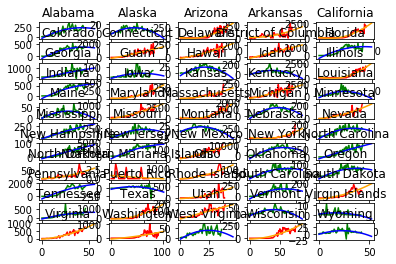

In [4]:
main()